# Organic Carbon Content Prediction

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize, StandardScaler
from sklearn.neighbors.kde import KernelDensity
from sklearn.linear_model import LinearRegression, Ridge, Lasso, RidgeCV
from sklearn.cluster import KMeans
from sklearn.model_selection import cross_val_score, train_test_split

In [2]:
data = "C:/Users/danie/Documents/EPFL MA1/Fall 1/Machine Learning/Carbon Analysis Project/data"

In [3]:
df_meas = pd.read_csv(data + "/IMPROVE_2015_measures_cs433.csv")
df_spec = pd.read_csv(data + "/IMPROVE_2015_raw_spectra_cs433.csv")
df_split = pd.read_csv(data + "/IMPROVE_2015_train_test_split_cs433.csv")
df_derive = pd.read_csv(data + "/IMPROVE_2015_2nd-derivative_spectra_cs433.csv")

## Raw Data Train and Test

In [4]:
df_meas = df_meas.set_index("site")
df_OC = pd.DataFrame(df_meas[["OCf:Value","OCf:Unc"]])
df_spec = df_spec.T
"""Align spectra with measurements"""
pd_merged_OC_spec = df_OC.merge(df_spec, right_index=True, left_index=True) #merge OC,OC unc and Spectra

df_split = df_split.set_index("site", drop=True).drop(["Unnamed: 0"], axis=1) #drop last column and set site as index
pd_merged_OC_spec_split = pd_merged_OC_spec.merge(df_split, right_index=True, left_index=True) #merge with split 
del pd_merged_OC_spec #don't need it anymore

In [6]:
"""Set training and test data"""
set_train = pd_merged_OC_spec_split[pd_merged_OC_spec_split["usage"] == "calibration"]
set_test = pd_merged_OC_spec_split[pd_merged_OC_spec_split["usage"] == "test"]

In [7]:
"""Uncertainty Variables"""
df_OCU_tr = set_train["OCf:Unc"]
df_OCU_te = set_test["OCf:Unc"]
""" Training and test Variables"""
y_tr = set_train["OCf:Value"]
y_te = set_test["OCf:Value"]
x_tr = set_train.drop(["OCf:Value","OCf:Unc","usage"], axis=1)
x_te = set_test.drop(["OCf:Value","OCf:Unc","usage"], axis=1)


In [123]:
x_tr.head()

,0,1,2,3,4,5,6,7,8,9,...,2774,2775,2776,2777,2778,2779,2780,2781,2782,2783
CRLA1_04_21_2015_NM_0_csv,0.99057,0.99010,0.98964,0.98917,0.98869,0.98822,0.98776,0.98731,0.98685,0.98640,...,-0.137450,-0.137830,-0.138150,-0.138390,-0.138530,-0.138560,-0.138480,-0.138240,-0.137840,-0.137270
TONT1_05_09_2015_NM_0_csv,0.31219,0.31199,0.31178,0.31157,0.31137,0.31116,0.31096,0.31075,0.31055,0.31034,...,-0.063570,-0.063091,-0.062506,-0.061798,-0.060950,-0.059964,-0.058836,-0.057547,-0.056065,-0.054372
BADL1_11_26_2015_NM_0_csv,0.58565,0.58535,0.58505,0.58475,0.58446,0.58417,0.58389,0.58361,0.58332,0.58303,...,-0.099381,-0.098669,-0.097782,-0.096701,-0.095394,-0.093851,-0.092053,-0.089964,-0.087558,-0.084833
BRID1_10_27_2015_NM_0_csv,0.63373,0.63343,0.63314,0.63284,0.63253,0.63223,0.63192,0.63163,0.63133,0.63102,...,-0.102270,-0.101440,-0.100430,-0.099210,-0.097748,-0.096049,-0.094104,-0.091885,-0.089359,-0.086516
SEQU1_04_03_2015_NM_0_csv,0.51053,0.51023,0.50994,0.50964,0.50935,0.50905,0.50875,0.50846,0.50816,0.50786,...,-0.102490,-0.102690,-0.102870,-0.103020,-0.103120,-0.103160,-0.103110,-0.102930,-0.102600,-0.102110


## 2nd Derivative Train and Test 

In [16]:
df_derive = df_derive.T
pd_merged_der_OC_spec = df_OC.merge(df_derive, right_index=True, left_index=True)
pd_merged_der_OC_spec_split = pd_merged_der_OC_spec.merge(df_split, right_index=True, left_index=True)
set_train_der = pd_merged_der_OC_spec_split[pd_merged_der_OC_spec_split["usage"] == "calibration"]
set_test_der = pd_merged_der_OC_spec_split[pd_merged_der_OC_spec_split["usage"] == "test"]
del pd_merged_der_OC_spec


In [17]:
y_tr_der = set_train_der["OCf:Value"]
y_te_der = set_test_der["OCf:Value"]
x_tr_der = set_train_der.drop(["OCf:Value","OCf:Unc","usage"], axis=1)
x_te_der = set_test_der.drop(["OCf:Value","OCf:Unc","usage"], axis=1)

In [18]:
x_tr_der.head()

,0,1,2,3,4,5,6,7,8,9,...,2774,2775,2776,2777,2778,2779,2780,2781,2782,2783
CRLA1_04_21_2015_NM_0_csv,-1.664240e-07,-1.664240e-07,-1.664240e-07,-1.664240e-07,-1.664240e-07,-1.664240e-07,-1.664240e-07,-1.664240e-07,-1.664240e-07,-1.664240e-07,...,0.000076,0.000076,0.000076,0.000076,0.000076,0.000076,0.000076,0.000076,0.000076,0.000076
TONT1_05_09_2015_NM_0_csv,-2.567684e-07,-2.567684e-07,-2.567684e-07,-2.567684e-07,-2.567684e-07,-2.567684e-07,-2.567684e-07,-2.567684e-07,-2.567684e-07,-2.567684e-07,...,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098,0.000098
BADL1_11_26_2015_NM_0_csv,-3.991203e-07,-3.991203e-07,-3.991203e-07,-3.991203e-07,-3.991203e-07,-3.991203e-07,-3.991203e-07,-3.991203e-07,-3.991203e-07,-3.991203e-07,...,0.000160,0.000160,0.000160,0.000160,0.000160,0.000160,0.000160,0.000160,0.000160,0.000160
BRID1_10_27_2015_NM_0_csv,4.606378e-08,4.606378e-08,4.606378e-08,4.606378e-08,4.606378e-08,4.606378e-08,4.606378e-08,4.606378e-08,4.606378e-08,4.606378e-08,...,0.000170,0.000170,0.000170,0.000170,0.000170,0.000170,0.000170,0.000170,0.000170,0.000170
SEQU1_04_03_2015_NM_0_csv,9.093881e-08,9.093881e-08,9.093881e-08,9.093881e-08,9.093881e-08,9.093881e-08,9.093881e-08,9.093881e-08,9.093881e-08,9.093881e-08,...,0.000047,0.000047,0.000047,0.000047,0.000047,0.000047,0.000047,0.000047,0.000047,0.000047


In [124]:
wave_no = df_spec.T['wavenumber'] # get wavenumbers

## Field Blank Extraction

In [19]:
""" Returns indexes of spectra that contain a specific label"""
def index_flag(x,label):
    x = x.values
    
    Comp =[]
    
    for Sample_ID in x:
        splits = Sample_ID.split('_')
        if len(splits)>4:
            flag = splits[4]
        else:
            flag = 'NM'
        Comp.append(flag==label)
    return Comp

In [126]:
idx_FB = index_flag(df_spec.index,'FB')
FBs = df_spec[idx_FB]
idx_FB_der = index_flag(df_derive.index,'FB')
FBs_der = df_derive[idx_FB_der]

## Raw Data FBs 

The number of Field Blanks is 463


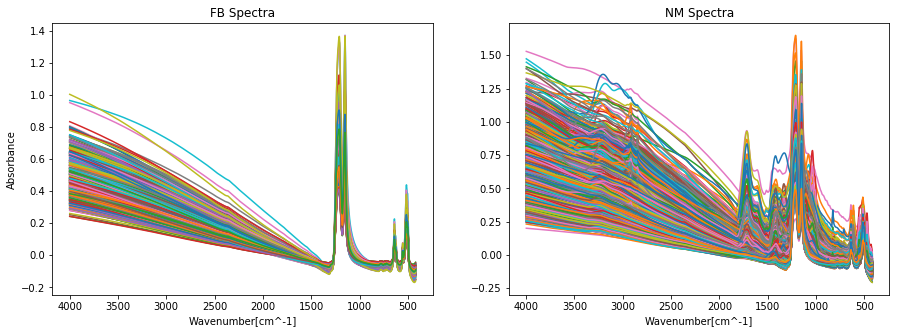

In [171]:
fig1 = plt.figure(figsize=(15,5))
ax1 = fig1.add_subplot(1,2,1)
ax1.plot(wave_no,FBs.T)
ax1.invert_xaxis()
ax1.set_xlabel('Wavenumber[cm^-1]')
ax1.set_ylabel('Absorbance')
ax1.set_title('FB Spectra')
ax2 = fig1.add_subplot(1,2,2)
ax2.plot(wave_no,x_tr.T)
ax2.set_xlabel('Wavenumber[cm^-1]')
ax2.invert_xaxis()
ax2.set_title('NM Spectra')
print('The number of Field Blanks is',np.shape(FBs_der)[0])

## 2nd Derivative FB

The number of Field Blanks is 463


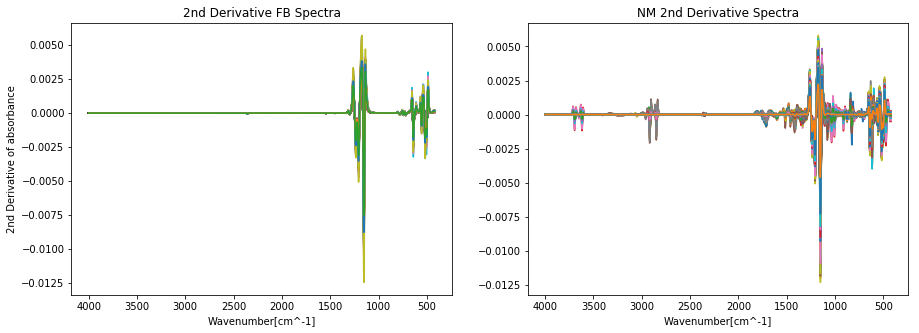

In [173]:
fig2 = plt.figure(figsize=(15,5))
ax1 = fig2.add_subplot(1,2,1)
ax1.plot(wave_no,FBs_der.T)
ax1.invert_xaxis()
ax1.set_xlabel('Wavenumber[cm^-1]')
ax1.set_ylabel('2nd Derivative of absorbance')
ax1.set_title('2nd Derivative FB Spectra')
ax2 = fig2.add_subplot(1,2,2)
ax2.plot(wave_no,x_tr_der.T)
ax2.set_xlabel('Wavenumber[cm^-1]')
ax2.invert_xaxis()
ax2.set_title('NM 2nd Derivative Spectra')
print('The number of Field Blanks is',np.shape(FBs_der)[0])

We can see that there are some regions that are completely flat. We can try to remove these features to save computational power

# Remove zero-features from derivative data

In [149]:

mean_der_spec=np.mean(abs(x_tr_der)) #compute the mean of the abs value of all samples
imp_feat = np.argwhere((mean_der_spec)>1e-6) #only take features whose average is higher than 5e-6
imp_feat #these are the non-zero features

array([[  64],
       [  65],
       [  66],
       ...,
       [2781],
       [2782],
       [2783]], dtype=int64)

In [185]:
x_tr_der_filtered = x_tr_der.iloc[:,imp_feat.flatten()] 
x_te_der_filtered = x_te_der.iloc[:,imp_feat.flatten()]
x_tr_der_compare = np.zeros((2784,))
x_tr_der_compare[imp_feat.flatten()] = mean_der_spec[imp_feat.flatten()]

The number of important features is 2126


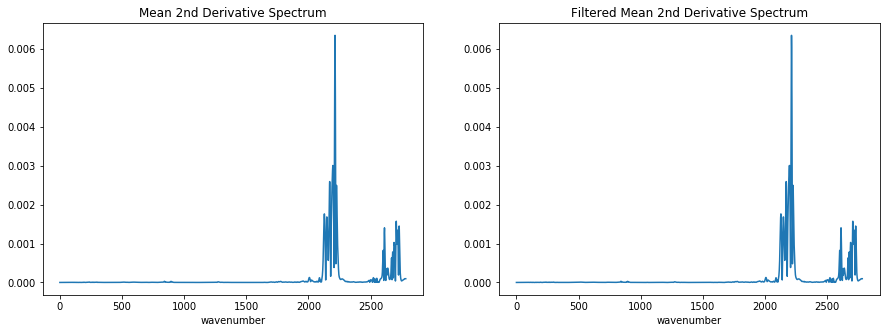

In [151]:
fig = plt.figure(figsize=(15,5))  # create a figure object
ax1 = fig.add_subplot(1, 2, 1)  # create an axes object in the figure
ax1.plot(np.arange(2784),mean_der_spec)
ax1.set_xlabel('wavenumber')
ax1.set_title('Mean 2nd Derivative Spectrum')
ax2 = fig.add_subplot(1,2,2)
ax2.plot(np.arange(2784),x_tr_der_compare)
ax2.set_xlabel('wavenumber')
ax2.set_title('Filtered Mean 2nd Derivative Spectrum')

print('The number of important features is',np.shape(x_tr_der_filtered)[1])


In [152]:
"""Compared filtered Data using linear regression as a first step"""
lr = LinearRegression()
lr.fit(x_tr_der_filtered,y_tr)
y_pred_der_filtered = lr.predict(x_tr_der_filtered)

lr2 = LinearRegression()
lr2.fit(x_tr_der,y_tr)
y_pred_der = lr2.predict(x_tr_der)



The r2 score of the full spectra is  0.9938952210387547
The r2 score of the filtered spectra is  0.9933245988845399


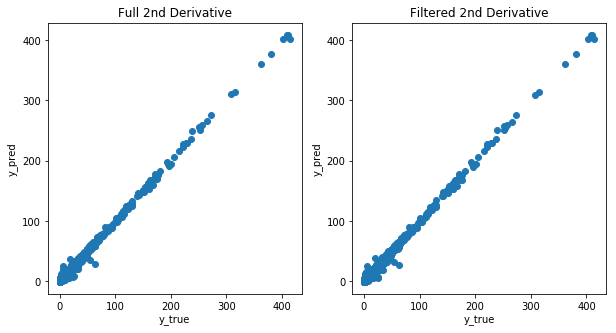

In [153]:
fig2 = plt.figure(figsize=(10,5))
ax1 = fig2.add_subplot(1,2,1)
ax1.scatter(y_tr,y_pred_der)
ax1.set_title('Full 2nd Derivative')
ax1.set_xlabel('y_true')
ax1.set_ylabel('y_pred')
ax2 = fig2.add_subplot(1,2,2)
ax2.scatter(y_tr,y_pred_der_filtered)
ax2.set_title('Filtered 2nd Derivative')
ax2.set_xlabel('y_true')
ax2.set_ylabel('y_pred')
print('The r2 score of the full spectra is ',r2_score(y_tr,y_pred_der))
print('The r2 score of the filtered spectra is ',r2_score(y_tr,y_pred_der_filtered))

We see that the linear regression does not change by much, and so we can remove the computational cost of ~700 features. 

# Alternative Smoothing Strategies: PCA
We can also extract the features that have the largest variance in the training set. Before doing so, we can remove the features that have the highest variance in the FB since these represent noise. After doing so we can get the principal components of the set. 

## Remove High variance from FB
In order to obtain the samples with highest variance in the FB we must standardize the data and then extract the largest variance

We can remove all the features with variance larger than 0.01


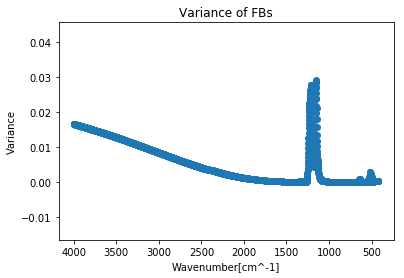

In [182]:
scaler = StandardScaler()
scaler.fit(FBs)
FBs_Std = scaler.transform(FBs)

plt.scatter(wave_no,scaler.var_)
ax = plt.gca()
ax.invert_xaxis()
ax.set_title('Variance of FBs')
ax.set_xlabel('Wavenumber[cm^-1]')
ax.set_ylabel('Variance')
print('We can remove all the features with variance larger than 0.01')


In [203]:
idx_low_var_FB = np.argwhere(scaler.var_<0.01).flatten()
x_tr_filtered = x_tr.iloc[:,idx_low_var_FB]
x_te_filtered = x_te.iloc[:,idx_low_var_FB]

## Applying PCA to the low variance x_tr
Now that we removed the noise from the FB, we can apply PCA with ~200 components. 

In [190]:
pca = PCA(n_components=200)
pca_tr = pca.fit_transform(x_tr_filtered)
pca_te = pca.transform(x_te_filtered)


# Model Comparison 
We will proceed to compare different regression models on the raw data, the filtered 2nd derivative data and the PC data.  We will compare them using 2 metrics: the bias metric (explained below) and the r2. The best model will minimize both of these quantities. 

##  Useful Functions

# Bias metric
This metric will allow us to compare the models based on their bias. It will compute the bias as y=(y_pred-y)/y_uc where y_uc is the signal uncertainty, y is the true y value and y_pred is the prediction from the model. It will also compute the signal to noise ratio (SNR) as y/y_uc. Then, it will smoothen the data by taking a moving average with 10% of the data. 

In [154]:
def compute_bias_metric_noplot(bias, SNR):
    
    # k = percent of data size for smoothing
    k = 0.1
    
    
    # take only samples with SNR > 2
    SNR_ind2 = np.argwhere(SNR > 2).flatten()
    # Bandwidth 
    bandwidth = round(k*len(SNR_ind2))
    # Normalize bias
    bias_n = np.array(bias[SNR_ind2]).flatten()
    # Stack to sort
    
    data = np.stack((np.array(SNR[SNR_ind2]).flatten(),bias_n),axis=0)
    data_sorted = data[:,data.argsort()[0]] #sort with respect to SNR
    y=[]
    for i in range(int(1/k)):
            y.append(np.mean(data_sorted[1,i*bandwidth:(i+1)*bandwidth]))
           
    # Smoother = Moving average, bandwidth of 10% of Data
    return np.max(np.abs(y))

## Cross Validation
This function will perform random cross validation. At each fold it will evaluate the bias metric, the MSE and the r2 with respect to the test sample, which is chosen randomly. The function build-k indices generates an array of k rows containing equal number of indices on each row. Each fold will take a row of this matrix as the test set. Additionally, the function plots the y_pred,y_true on the left, and will give the bias plot as well. 

In [155]:
def build_k_indices(y, k_fold, seed):
    """Permutates data randomly and organizes indices in k rows"""
    num_row = y.shape[0]
    interval = int(num_row / k_fold)
    np.random.seed(seed)
    indices = np.random.permutation(num_row)
    k_indices = [indices[k * interval: (k + 1) * interval] for k in range(k_fold)]

    return np.array(k_indices)

In [166]:
def cross_validation_random(x_tr,y_tr,y_uc,regression_method,plot_title,k_fold=4,seed=1):
    """Splits training data into train and test. 
    cv_type = str representing how the test and train samples will be split
    Random Cross Validation split into k -folds. 
    Function outputs validation bias plot and regression plot
    Function outputs avg mse, r2, bias metric, and sample size
    """
    reg=eval(regression_method)
    indices=build_k_indices(y_tr,k_fold,seed)
        
    avg_mse = 0
    avg_r2 = 0
    avg_bias = 0
    
    y_pred_shuffled = []
    y_true_shuffled = []
    uc_shuffled = []
    
    for k in range(k_fold):
            #training sub data
            x_te_sub = x_tr.iloc[indices[k],:]
            y_te_sub = y_tr[indices[k]]
            y_te_sub_uc = y_uc[indices[k]]
            

            #drop training indices, select test subdata
            #indices_ = np.delete(indices, (k), axis=0).flatten() #Take the complement of the data as test
            indices_ = np.delete(indices, (k), axis=0).flatten()[:int(len(y_tr)/2)] #take half of the train data
            x_tr_sub = x_tr.iloc[indices_,:]
            y_tr_sub = y_tr[indices_]
            

            reg.fit(x_tr_sub,y_tr_sub)
            y_te_sub_pred = reg.predict(x_te_sub)
            
            
            #Bias Calculation
            SNR_sub = y_te_sub/y_te_sub_uc
            bias_te_sub = (y_te_sub_pred - y_te_sub) / y_te_sub_uc
            bias_metric = compute_bias_metric_noplot(bias_te_sub,SNR_sub)
            
            #Compute loss and r2
            avg_mse = avg_mse+mean_squared_error(y_te_sub,y_te_sub_pred)
            avg_r2 = avg_r2+ r2_score(y_te_sub, y_te_sub_pred)
            avg_bias = avg_bias + bias_metric
            
            #Plot 
            plt.scatter(y_te_sub,y_te_sub_pred)
            y_pred_shuffled.append(y_te_sub_pred)
            y_true_shuffled.append(y_te_sub)
            uc_shuffled.append(y_te_sub_uc)
            
            print('Fold # %i Test mean squared error: %.2f' % (k+1,mean_squared_error(y_te_sub, y_te_sub_pred)))
            print('Fold # %i Test R2: %.2f' % (k+1,r2_score(y_te_sub, y_te_sub_pred)))
            print('Fold # %i Test bias metric: %.2f' % (k+1,bias_metric))
    print('Training Sample Size: ',int(len(y_tr)*(k_fold-1)/k_fold))
    plt.suptitle(plot_title, fontsize=20)
    u = np.linspace(0,500)
    plt.plot(u,u, c='black')
    plt.xlabel('y_true', fontsize=18)
    plt.ylabel('y_pred_cv', fontsize=16)
    plt.show()
    
   
    bias_plot(pd.Series(np.array(y_true_shuffled).flatten()),np.array(y_pred_shuffled).flatten(),np.array(uc_shuffled).flatten())
    return  avg_mse/k_fold,avg_r2/k_fold,avg_bias/k_fold,int(len(y_tr)*(k_fold-1)/k_fold)

In [167]:
import seaborn as sns

def bias_plot(y_right, y_pred, OCU):
    """Produces a nice visualization of the bias"""
    bias = (y_pred - y_right) / OCU
    SNR = y_right / OCU
    SNR.name = 'SNR'
    bias.name = 'bias'
    pd_plot = pd.concat([SNR, bias], axis=1)


    sns.jointplot("SNR", "bias", data=pd_plot, kind='reg', scatter_kws={"s": 2},
                  joint_kws={'line_kws':{'color':'black'}});

## Linear Regression Raw Data
We will start with the simplest model on the raw data

Fold # 1 Test mean squared error: 6.79
Fold # 1 Test R2: 0.98
Fold # 1 Test bias metric: 0.42
Fold # 2 Test mean squared error: 6.63
Fold # 2 Test R2: 0.97
Fold # 2 Test bias metric: 0.23
Fold # 3 Test mean squared error: 6.62
Fold # 3 Test R2: 0.97
Fold # 3 Test bias metric: 0.32
Fold # 4 Test mean squared error: 9.75
Fold # 4 Test R2: 0.97
Fold # 4 Test bias metric: 0.32
Training Sample Size:  10021


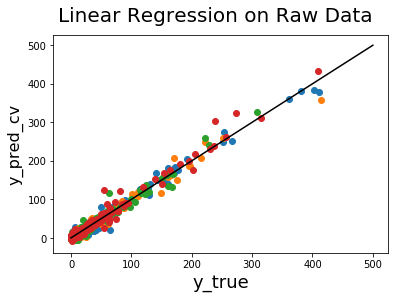

c:\users\danie\appdata\local\programs\python\python37\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


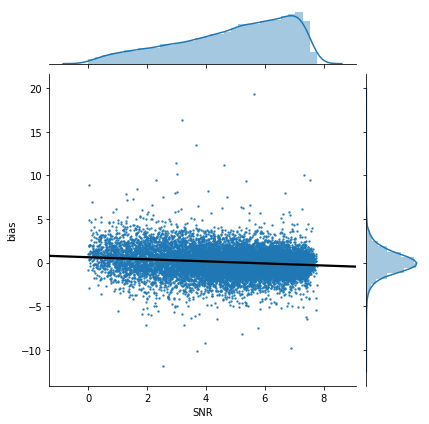

In [168]:
MSE_lin,R2_lin,Biasm_lin,train_size = cross_validation_random(x_tr,y_tr,df_OCU_tr,'LinearRegression()','Linear Regression on Raw Data',4) #Raw model

## Linear Regression on Derivative Data

Fold # 1 Test mean squared error: 5.71
Fold # 1 Test R2: 0.99
Fold # 1 Test bias metric: 0.63
Fold # 2 Test mean squared error: 7.26
Fold # 2 Test R2: 0.97
Fold # 2 Test bias metric: 0.59
Fold # 3 Test mean squared error: 4.72
Fold # 3 Test R2: 0.98
Fold # 3 Test bias metric: 0.70
Fold # 4 Test mean squared error: 6.59
Fold # 4 Test R2: 0.98
Fold # 4 Test bias metric: 0.65
Training Sample Size:  10021


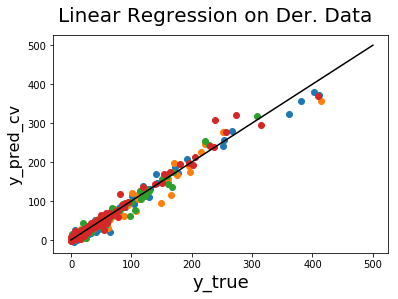

c:\users\danie\appdata\local\programs\python\python37\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


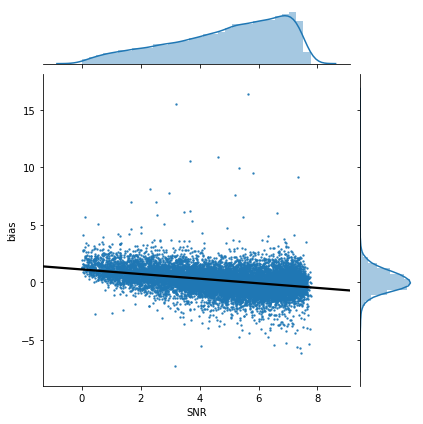

In [197]:
MSE_ridge_der,R2_ridge_der,Biasm_ridge_der,train_size = cross_validation_random(x_tr_der,y_tr,df_OCU_tr,'Ridge(alpha=1e-6)','Linear Regression on Der. Data',4) #Raw model

## Linear Regression Filtered Derivative Data

Fold # 1 Test mean squared error: 5.91
Fold # 1 Test R2: 0.99
Fold # 1 Test bias metric: 0.35
Fold # 2 Test mean squared error: 5.96
Fold # 2 Test R2: 0.98
Fold # 2 Test bias metric: 0.21
Fold # 3 Test mean squared error: 6.24
Fold # 3 Test R2: 0.97
Fold # 3 Test bias metric: 0.36
Fold # 4 Test mean squared error: 8.16
Fold # 4 Test R2: 0.97
Fold # 4 Test bias metric: 0.38
Training Sample Size:  10021


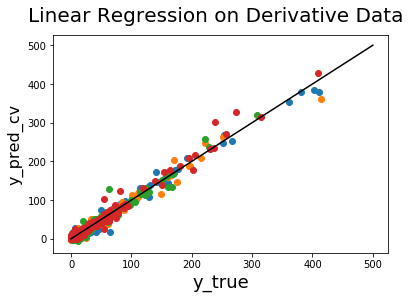

c:\users\danie\appdata\local\programs\python\python37\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


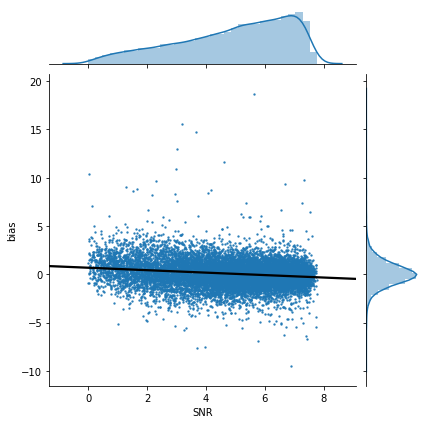

In [170]:
MSE_lin_der_filtered,R2_lin_der_filtered,Biasm_lin_der_filtered,train_size = cross_validation_random(x_tr_der_filtered,y_tr,df_OCU_tr,'LinearRegression()','Linear Regression on Filtered Derivative Data',4) #der data

## Linear Regression on PC Set

Fold # 1 Test mean squared error: 5.52
Fold # 1 Test R2: 0.99
Fold # 1 Test bias metric: 0.45
Fold # 2 Test mean squared error: 5.31
Fold # 2 Test R2: 0.98
Fold # 2 Test bias metric: 0.40
Fold # 3 Test mean squared error: 4.96
Fold # 3 Test R2: 0.98
Fold # 3 Test bias metric: 0.47
Fold # 4 Test mean squared error: 6.02
Fold # 4 Test R2: 0.98
Fold # 4 Test bias metric: 0.35
Training Sample Size:  10021


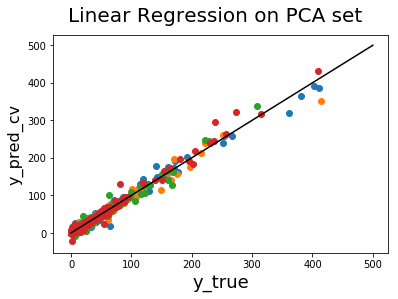

c:\users\danie\appdata\local\programs\python\python37\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


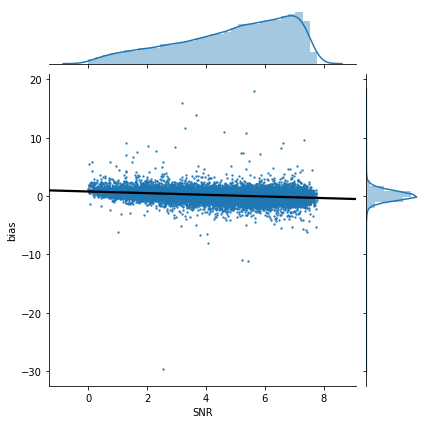

In [192]:
MSE_lin_PCA,R2_lin_PCA,Biasm_lin_PCA,train_size = cross_validation_random(pd.DataFrame(pca_tr),y_tr,df_OCU_tr,'LinearRegression()','Linear Regression on PCA set',4) #der data

Comparing the three data sets, it seems that the PCA linear regression gives very good results

## Ridge Regression Raw Data
We will implement ridge regression with an alpha obtained by trial an error trying to maximize performance. 

Fold # 1 Test mean squared error: 5.28
Fold # 1 Test R2: 0.99
Fold # 1 Test bias metric: 0.37
Fold # 2 Test mean squared error: 4.67
Fold # 2 Test R2: 0.98
Fold # 2 Test bias metric: 0.36
Fold # 3 Test mean squared error: 4.66
Fold # 3 Test R2: 0.98
Fold # 3 Test bias metric: 0.44
Fold # 4 Test mean squared error: 6.35
Fold # 4 Test R2: 0.98
Fold # 4 Test bias metric: 0.39
Training Sample Size:  10021


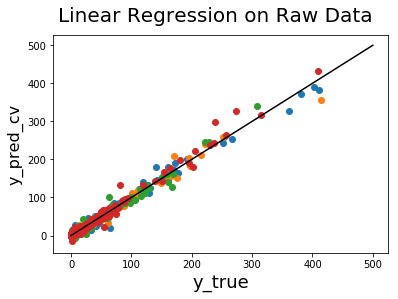

c:\users\danie\appdata\local\programs\python\python37\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


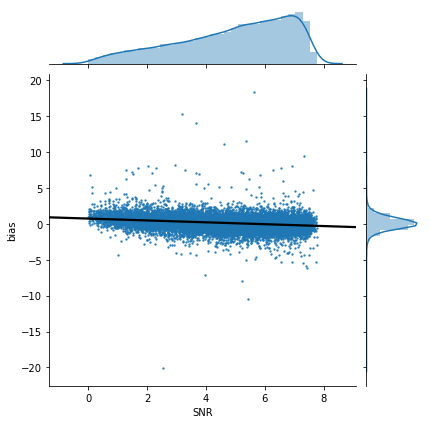

In [193]:
MSE_ridge,R2_ridge,Biasm_ridge,train_size = cross_validation_random(x_tr,y_tr,df_OCU_tr,'Ridge(alpha=1e-6)','Ridge Regression on Raw Data',4) #Raw model

## Ridge Regression 2nd Derivative

Fold # 1 Test mean squared error: 5.71
Fold # 1 Test R2: 0.99
Fold # 1 Test bias metric: 0.63
Fold # 2 Test mean squared error: 7.26
Fold # 2 Test R2: 0.97
Fold # 2 Test bias metric: 0.59
Fold # 3 Test mean squared error: 4.72
Fold # 3 Test R2: 0.98
Fold # 3 Test bias metric: 0.70
Fold # 4 Test mean squared error: 6.59
Fold # 4 Test R2: 0.98
Fold # 4 Test bias metric: 0.65
Training Sample Size:  10021


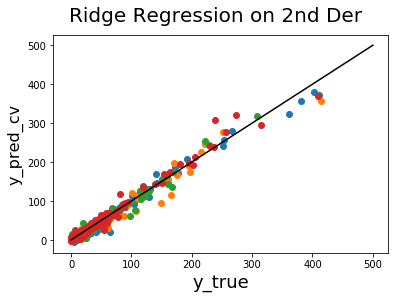

c:\users\danie\appdata\local\programs\python\python37\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


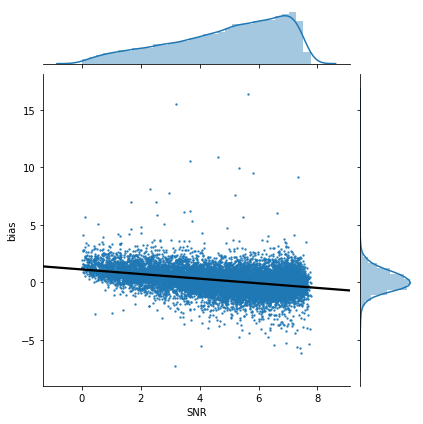

In [199]:
MSE_ridge_der,R2_ridge_der,Biasm_ridge_der,train_size = cross_validation_random(x_tr_der,y_tr,df_OCU_tr,'Ridge(alpha=1e-6)','Ridge Regression on 2nd Der',4) #Raw model

## Ridge Regression Filtered 2nd Derivative

Fold # 1 Test mean squared error: 5.71
Fold # 1 Test R2: 0.99
Fold # 1 Test bias metric: 0.63
Fold # 2 Test mean squared error: 7.27
Fold # 2 Test R2: 0.97
Fold # 2 Test bias metric: 0.59
Fold # 3 Test mean squared error: 4.72
Fold # 3 Test R2: 0.98
Fold # 3 Test bias metric: 0.70
Fold # 4 Test mean squared error: 6.60
Fold # 4 Test R2: 0.98
Fold # 4 Test bias metric: 0.65
Training Sample Size:  10021


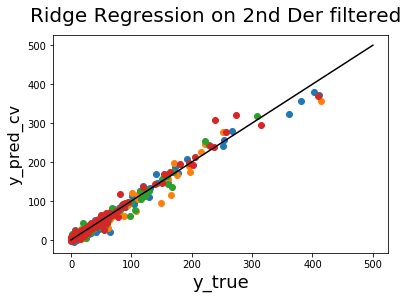

c:\users\danie\appdata\local\programs\python\python37\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


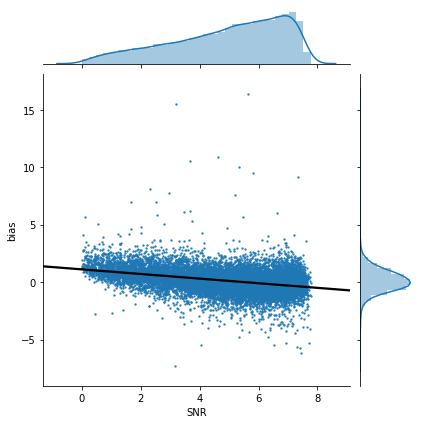

In [200]:
MSE_ridge_der_filtered,R2_ridge_der_filtered,Biasm_ridge_der_filtered,train_size = cross_validation_random(x_tr_der_filtered,y_tr,df_OCU_tr,'Ridge(alpha=1e-6)','Ridge Regression on 2nd Der filtered',4) #Raw model

## Ridge Regression PC Set

Fold # 1 Test mean squared error: 5.52
Fold # 1 Test R2: 0.99
Fold # 1 Test bias metric: 0.45
Fold # 2 Test mean squared error: 5.31
Fold # 2 Test R2: 0.98
Fold # 2 Test bias metric: 0.40
Fold # 3 Test mean squared error: 4.95
Fold # 3 Test R2: 0.98
Fold # 3 Test bias metric: 0.47
Fold # 4 Test mean squared error: 6.01
Fold # 4 Test R2: 0.98
Fold # 4 Test bias metric: 0.35
Training Sample Size:  10021


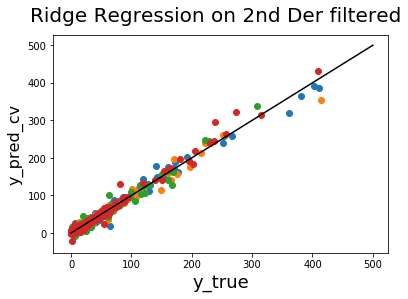

c:\users\danie\appdata\local\programs\python\python37\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


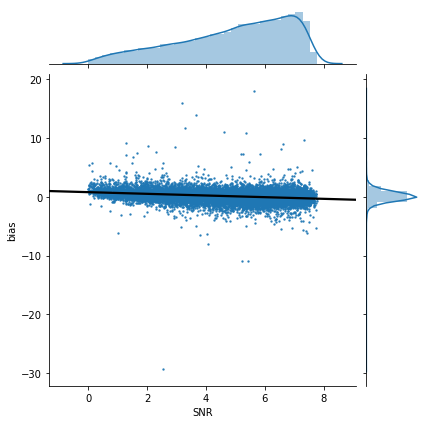

In [201]:
MSE_ridge_pca,R2_ridge_pca,Biasm_ridge_pca,train_size = cross_validation_random(pd.DataFrame(pca_tr),y_tr,df_OCU_tr,'Ridge(alpha=1e-6)','Ridge Regression on PCA set',4) #Raw model